In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
import tensorflow as tf
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

In [11]:
df = pd.read_csv('../data/traintest.csv')

### 데이터 전처리

In [12]:
# 요일 원-핫 인코딩
day_dummies = pd.get_dummies(df['요일'])
df = pd.concat([df, day_dummies], axis=1)

# date(year-month-day)
df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# 가격
def replace_zero_with_mean(df, column):
    for i in range(len(df)):
        if df[column][i] == 0:
            if i == 0:
                df.at[i, column] = (df[column][i+1] + df[column][i+2])/2
            elif i == len(df) - 1:
                df.at[i, column] = (df[column][i-1] + df[column][i-2])/2
            else:
                df.at[i, column] = (df[column][i-1] + df[column][i+1]) / 2

for col in df.columns:
    if '_가격(원/kg)' in col:
        replace_zero_with_mean(df, col)

# STL 시계열 잔차/추세
df['resid'] = 0
stl = STL(df[['date', '사과_가격(원/kg)']].set_index('date'), period=12)
res = stl.fit()
df['resid'] = res.resid.values

### Modeling

feature selection 기능이 없는 lstm의 특성을 고려하여 예측하고자 하는 target feature만 feature로 활용

- 가격 예측

In [4]:
feature = ['사과_거래량(kg)', 'year', 'month', 'day', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', 'resid']
x = df[feature].values
y = df['사과_가격(원/kg)'].values.reshape(-1, 1)

# 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

# LSTM을 위해 3D 입력 형태로 변환 (samples, timesteps, feature)
x_lstm = np.reshape(x_scaled, (x_scaled.shape[0], 1, x_scaled.shape[1]))

x_train, x_test, y_train, y_test = train_test_split(x_lstm, y_scaled, test_size=0.25, random_state=42)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0860 - val_loss: 0.0231
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0280 - val_loss: 0.0218
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0259 - val_loss: 0.0216
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0248 - val_loss: 0.0215
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0254 - val_loss: 0.0213
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0258 - val_loss: 0.0212
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0235 - val_loss: 0.0215
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0222 - val_loss: 0.0212
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0242 - val_loss: 0.0214
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0231 - val_loss: 0.0213
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0237 - val_loss: 0.0212
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0217 - val_l

In [5]:
train_loss = model.evaluate(x_train, y_train)
test_loss = model.evaluate(x_test, y_test)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# train
y_train_pred_scaled = model.predict(x_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_inv = scaler_y.inverse_transform(y_train)

train_mae = mean_absolute_error(y_train_inv, y_train_pred)
train_mse = mean_squared_error(y_train_inv, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, y_train_pred)

print("Train Mean Absolute Error (MAE):", train_mae)
print("Train Mean Squared Error (MSE):", train_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R² Score:", train_r2)

# test
y_pred_scaled = model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# print("LSTM 예측 결과:", y_pred)

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print("Test Mean Absolute Error (MAE):", mae)
print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", rmse)
print("Test R² Score:", r2)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 
Train Loss: 0.018304875120520592
Test Loss: 0.01913321577012539
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Train Mean Absolute Error (MAE): 622.0425766015965
Train Mean Squared Error (MSE): 628511.5489173873
Train Root Mean Squared Error (RMSE): 792.7872027961773
Train R² Score: 0.35681978596242425
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Mean Absolute Error (MAE): 637.9878508212892
Test Mean Squared Error (MSE): 656953.3231251576
Test Root Mean Squared Error (RMSE): 810.5265715108652
Test R² Score: 0.20913067234169913


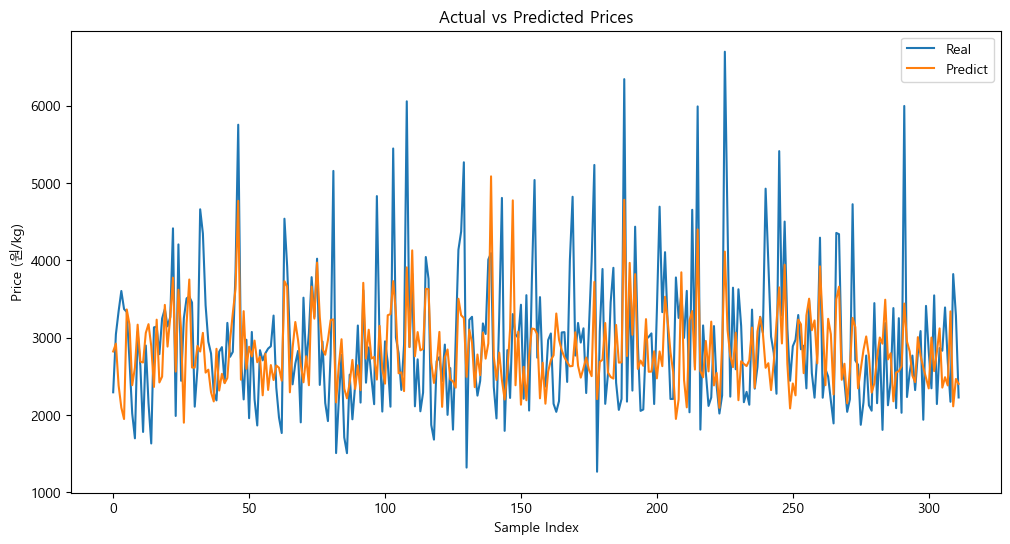

In [6]:
plt.figure(figsize=(12, 6))

plt.plot(range(len(y_test_inv)), y_test_inv, label='Real')
plt.plot(range(len(y_pred)), y_pred, label='Predict')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price (원/kg)')
plt.legend()
plt.show()

In [10]:
dfeature = ['사과_거래량(kg)', 'year', 'month', 'day', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', 'resid']
x = df[feature].values
y = df['사과_가격(원/kg)']

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# x,y는 2D 배열로 변환하여 스케일링
x_scaled = scaler_x.fit_transform(x)
y = y.values.reshape(-1, 1)
y_scaled = scaler_y.fit_transform(y)

# 시계열 데이터 형태로 변환 (samples, timesteps, feature)
def create_sequences(data, target, step):
    x_seq, y_seq = [], []
    for i in range(len(data) - step):
        x_seq.append(data[i:i + step])
        y_seq.append(target[i + step])
    return np.array(x_seq), np.array(y_seq)

timesteps = 7
x_lstm, y_lstm = create_sequences(x_scaled, y_scaled, timesteps)


x_train, x_test, y_train, y_test = train_test_split(x_lstm, y_lstm, test_size=0.25, random_state=42)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))  # Dropout을 사용하여 과적합 방지
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # 출력층: 1개 노드

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=2)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 - 9s - 305ms/step - loss: 0.0317 - val_loss: 0.0272
Epoch 2/50
29/29 - 0s - 13ms/step - loss: 0.0253 - val_loss: 0.0253
Epoch 3/50
29/29 - 1s - 25ms/step - loss: 0.0244 - val_loss: 0.0249
Epoch 4/50
29/29 - 0s - 13ms/step - loss: 0.0240 - val_loss: 0.0250
Epoch 5/50
29/29 - 0s - 12ms/step - loss: 0.0231 - val_loss: 0.0244
Epoch 6/50
29/29 - 0s - 14ms/step - loss: 0.0211 - val_loss: 0.0247
Epoch 7/50
29/29 - 1s - 24ms/step - loss: 0.0204 - val_loss: 0.0228
Epoch 8/50
29/29 - 0s - 12ms/step - loss: 0.0191 - val_loss: 0.0207
Epoch 9/50
29/29 - 0s - 11ms/step - loss: 0.0177 - val_loss: 0.0185
Epoch 10/50
29/29 - 0s - 12ms/step - loss: 0.0175 - val_loss: 0.0193
Epoch 11/50
29/29 - 0s - 11ms/step - loss: 0.0166 - val_loss: 0.0175
Epoch 12/50
29/29 - 0s - 15ms/step - loss: 0.0160 - val_loss: 0.0211
Epoch 13/50
29/29 - 1s - 26ms/step - loss: 0.0180 - val_loss: 0.0178
Epoch 14/50
29/29 - 1s - 26ms/step - loss: 0.0153 - val_loss: 0.0168
Epoch 15/50
29/29 - 0s - 14ms/step - loss:

In [11]:
train_loss = model.evaluate(x_train, y_train)
test_loss = model.evaluate(x_test, y_test)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# train
y_train_pred_scaled = model.predict(x_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_inv = scaler_y.inverse_transform(y_train)

train_mae = mean_absolute_error(y_train_inv, y_train_pred)
train_mse = mean_squared_error(y_train_inv, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, y_train_pred)

print("Train Mean Absolute Error (MAE):", train_mae)
print("Train Mean Squared Error (MSE):", train_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R² Score:", train_r2)

# test
y_pred_scaled = model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# print("LSTM 예측 결과:", y_pred)

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print("Test Mean Absolute Error (MAE):", mae)
print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", rmse)
print("Test R² Score:", r2)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095
Train Loss: 0.007627975195646286
Test Loss: 0.01091762725263834
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Train Mean Absolute Error (MAE): 396.74554999483394
Train Mean Squared Error (MSE): 261912.25571848286
Train Root Mean Squared Error (RMSE): 511.7736371858977
Train R² Score: 0.7214276675901334
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test Mean Absolute Error (MAE): 436.5355702911299
Test Mean Squared Error (MSE): 374864.9555026333
Test Root Mean Squared Error (RMSE): 612.2621623966594
Test R² Score: 0.5932778950035145


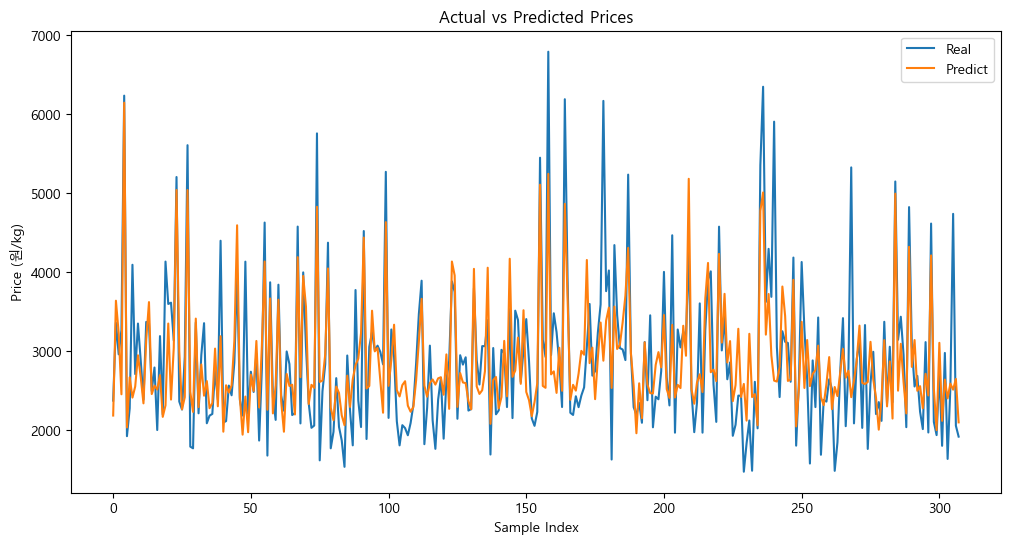

In [12]:
plt.figure(figsize=(12, 6))

plt.plot(range(len(y_test_inv)), y_test_inv, label='Real')
plt.plot(range(len(y_pred)), y_pred, label='Predict')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price (원/kg)')
plt.legend()
plt.show()

- 7일 후 가격 예측

In [7]:
df['target'] = df['사과_가격(원/kg)'].shift(-7)  # 7일 후의 사과 가격을 예측
df.dropna(inplace=True)

feature = ['사과_거래량(kg)', 'year', 'month', 'day', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', 'resid']
x = df[feature]
y = df['target']

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# x,y는 2D 배열로 변환하여 스케일링
x_scaled = scaler_x.fit_transform(x)
y = y.values.reshape(-1, 1)
y_scaled = scaler_y.fit_transform(y)

# 시계열 데이터 형태로 변환 (samples, timesteps, feature)
def create_sequences(data, target, step):
    x_seq, y_seq = [], []
    for i in range(len(data) - step):
        x_seq.append(data[i:i + step])
        y_seq.append(target[i + step])
    return np.array(x_seq), np.array(y_seq)

timesteps = 7
x_lstm, y_lstm = create_sequences(x_scaled, y_scaled, timesteps)


x_train, x_test, y_train, y_test = train_test_split(x_lstm, y_lstm, test_size=0.25, random_state=42)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))  # Dropout을 사용하여 과적합 방지
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # 출력층: 1개 노드

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=2)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 - 9s - 305ms/step - loss: 0.0379 - val_loss: 0.0242
Epoch 2/50
29/29 - 0s - 14ms/step - loss: 0.0273 - val_loss: 0.0242
Epoch 3/50
29/29 - 0s - 15ms/step - loss: 0.0263 - val_loss: 0.0240
Epoch 4/50
29/29 - 1s - 23ms/step - loss: 0.0258 - val_loss: 0.0235
Epoch 5/50
29/29 - 0s - 14ms/step - loss: 0.0248 - val_loss: 0.0232
Epoch 6/50
29/29 - 0s - 14ms/step - loss: 0.0240 - val_loss: 0.0222
Epoch 7/50
29/29 - 0s - 13ms/step - loss: 0.0228 - val_loss: 0.0203
Epoch 8/50
29/29 - 1s - 27ms/step - loss: 0.0201 - val_loss: 0.0173
Epoch 9/50
29/29 - 0s - 11ms/step - loss: 0.0196 - val_loss: 0.0177
Epoch 10/50
29/29 - 0s - 11ms/step - loss: 0.0193 - val_loss: 0.0165
Epoch 11/50
29/29 - 0s - 11ms/step - loss: 0.0192 - val_loss: 0.0158
Epoch 12/50
29/29 - 0s - 17ms/step - loss: 0.0177 - val_loss: 0.0175
Epoch 13/50
29/29 - 0s - 17ms/step - loss: 0.0185 - val_loss: 0.0155
Epoch 14/50
29/29 - 1s - 19ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 15/50
29/29 - 0s - 13ms/step - loss:

In [8]:
train_loss = model.evaluate(x_train, y_train)
test_loss = model.evaluate(x_test, y_test)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# train
y_train_pred_scaled = model.predict(x_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_inv = scaler_y.inverse_transform(y_train)

train_mae = mean_absolute_error(y_train_inv, y_train_pred)
train_mse = mean_squared_error(y_train_inv, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, y_train_pred)

print("Train Mean Absolute Error (MAE):", train_mae)
print("Train Mean Squared Error (MSE):", train_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R² Score:", train_r2)

# test
y_pred_scaled = model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# print("LSTM 예측 결과:", y_pred)

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print("Test Mean Absolute Error (MAE):", mae)
print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", rmse)
print("Test R² Score:", r2)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 
Train Loss: 0.01011443231254816
Test Loss: 0.011501203291118145
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Train Mean Absolute Error (MAE): 451.10148045544054
Train Mean Squared Error (MSE): 347286.5530681981
Train Root Mean Squared Error (RMSE): 589.3102349935881
Train R² Score: 0.644506402237182
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test Mean Absolute Error (MAE): 468.60459708903716
Test Mean Squared Error (MSE): 394902.3851187902
Test Root Mean Squared Error (RMSE): 628.412591470596
Test R² Score: 0.534754069278261


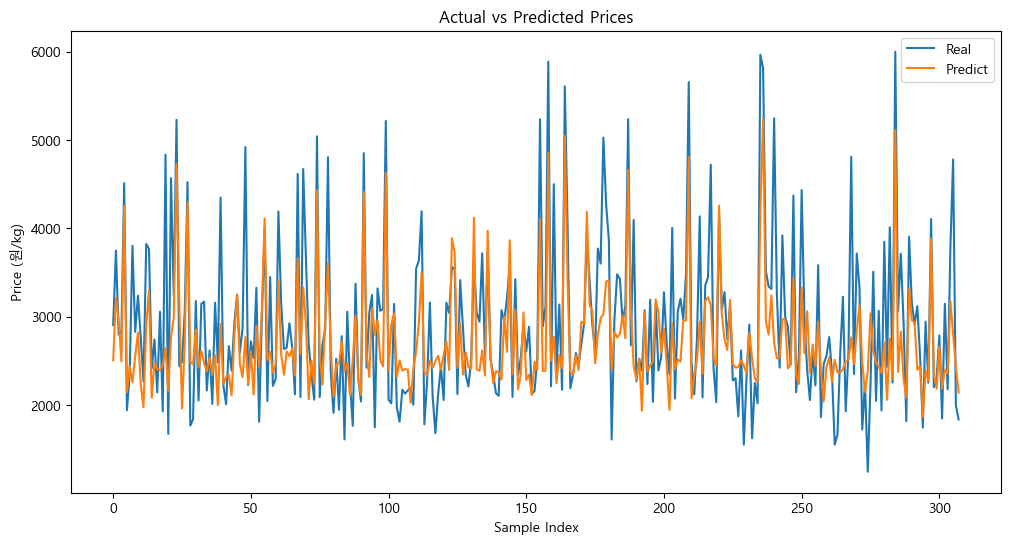

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(range(len(y_test_inv)), y_test_inv, label='Real')
plt.plot(range(len(y_pred)), y_pred, label='Predict')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price (원/kg)')
plt.legend()
plt.show()

##### LSTM 모델 개선

In [13]:
df['target'] = df['사과_가격(원/kg)'].shift(-7)  # 7일 후의 사과 가격을 예측
df.dropna(inplace=True)

feature = ['사과_거래량(kg)', 'year', 'month', 'day', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', 'resid']
x = df[feature]
y = df['target']

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# x,y는 2D 배열로 변환하여 스케일링
x_scaled = scaler_x.fit_transform(x)
y = y.values.reshape(-1, 1)
y_scaled = scaler_y.fit_transform(y)

# 시계열 데이터 형태로 변환 (samples, timesteps, feature)
def create_sequences(data, target, step):
    x_seq, y_seq = [], []
    for i in range(len(data) - step):
        x_seq.append(data[i:i + step])
        y_seq.append(target[i + step])
    return np.array(x_seq), np.array(y_seq)

timesteps = 7
x_lstm, y_lstm = create_sequences(x_scaled, y_scaled, timesteps)


x_train, x_test, y_train, y_test = train_test_split(x_lstm, y_lstm, test_size=0.25, random_state=42)

batch_size = 64  # 배치 크기 변경
epochs = 150  # 에폭 수 증가
dropout_rate = 0.4  # Dropout 비율 증가

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(dropout_rate))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(50))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_test, y_test), callbacks=[early_stopping], verbose=2)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
15/15 - 13s - 859ms/step - loss: 0.0452 - val_loss: 0.0328
Epoch 2/150
15/15 - 0s - 31ms/step - loss: 0.0300 - val_loss: 0.0255
Epoch 3/150
15/15 - 0s - 31ms/step - loss: 0.0267 - val_loss: 0.0257
Epoch 4/150
15/15 - 1s - 47ms/step - loss: 0.0270 - val_loss: 0.0254
Epoch 5/150
15/15 - 0s - 32ms/step - loss: 0.0263 - val_loss: 0.0255
Epoch 6/150
15/15 - 0s - 28ms/step - loss: 0.0260 - val_loss: 0.0255
Epoch 7/150
15/15 - 0s - 31ms/step - loss: 0.0257 - val_loss: 0.0251
Epoch 8/150
15/15 - 1s - 53ms/step - loss: 0.0254 - val_loss: 0.0252
Epoch 9/150
15/15 - 1s - 44ms/step - loss: 0.0261 - val_loss: 0.0249
Epoch 10/150
15/15 - 1s - 39ms/step - loss: 0.0259 - val_loss: 0.0250
Epoch 11/150
15/15 - 1s - 65ms/step - loss: 0.0242 - val_loss: 0.0232
Epoch 12/150
15/15 - 1s - 90ms/step - loss: 0.0233 - val_loss: 0.0218
Epoch 13/150
15/15 - 1s - 56ms/step - loss: 0.0222 - val_loss: 0.0196
Epoch 14/150
15/15 - 1s - 56ms/step - loss: 0.0213 - val_loss: 0.0187
Epoch 15/150
15/15 - 0s - 3

In [14]:
train_loss = model.evaluate(x_train, y_train)
test_loss = model.evaluate(x_test, y_test)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# train
y_train_pred_scaled = model.predict(x_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_inv = scaler_y.inverse_transform(y_train)

train_mae = mean_absolute_error(y_train_inv, y_train_pred)
train_mse = mean_squared_error(y_train_inv, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, y_train_pred)

print("Train Mean Absolute Error (MAE):", train_mae)
print("Train Mean Squared Error (MSE):", train_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R² Score:", train_r2)

# test
y_pred_scaled = model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# print("LSTM 예측 결과:", y_pred)

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print("Test Mean Absolute Error (MAE):", mae)
print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", rmse)
print("Test R² Score:", r2)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040
Train Loss: 0.0028370628133416176
Test Loss: 0.0038695859257131815
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
Train Mean Absolute Error (MAE): 227.36385832274357
Train Mean Squared Error (MSE): 97412.67390998916
Train Root Mean Squared Error (RMSE): 312.1100349395853
Train R² Score: 0.897311065826168
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test Mean Absolute Error (MAE): 253.30052337289828
Test Mean Squared Error (MSE): 132865.12480884945
Test Root Mean Squared Error (RMSE): 364.5066869192518
Test R² Score: 0.8543456321806894


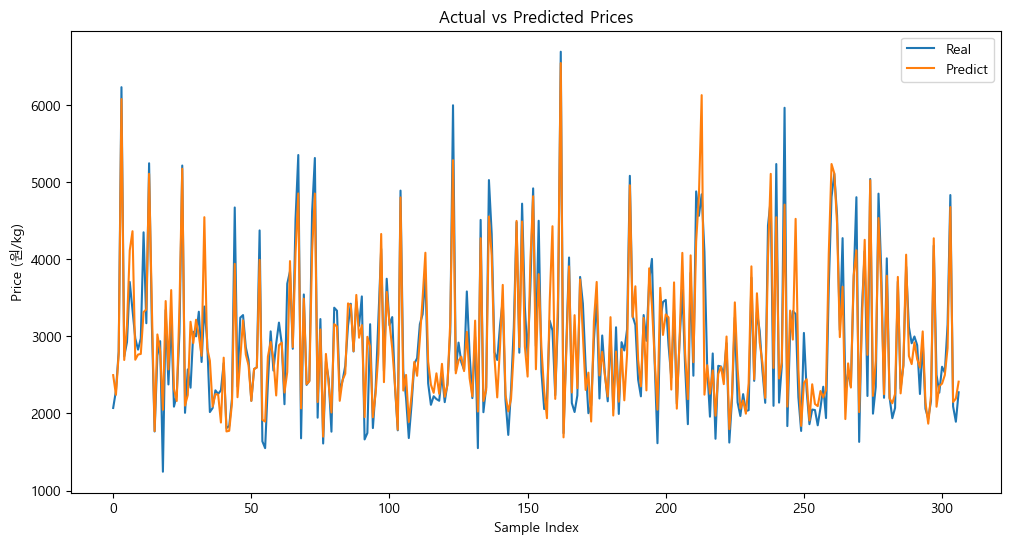

In [15]:
plt.figure(figsize=(12, 6))

plt.plot(range(len(y_test_inv)), y_test_inv, label='Real')
plt.plot(range(len(y_pred)), y_pred, label='Predict')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price (원/kg)')
plt.legend()
plt.show()

- 하이퍼파라미터 튜닝

In [16]:
def create_model(optimizer='adam', lstm_units=50, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 150],
    'model__lstm_units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'softmax']
}

# KerasRegressor로 래핑
model = KerasRegressor(model=create_model, verbose=0)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search_result = grid_search.fit(x_train, y_train)

print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))
best_model = grid_search_result.best_estimator_

y_pred_scaled = best_model.predict(x_test)

# 예측값과 실제값을 역변환
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best: 0.816093 using {'batch_size': 32, 'epochs': 150, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__lstm_units': 150, 'model__optimizer': 'adam'}
Mean Absolute Error (MAE): 227.85139576543625
Mean Squared Error (MSE): 95196.6545688953
Root Mean Squared Error (RMSE): 308.5395510609544
R² Score: 0.8923195824287564


In [18]:
y_pred_scaled = best_model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

print("LSTM 예측 결과:", y_pred)

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

train_score = best_model.score(x_train, y_train)
test_score = best_model.score(x_test, y_test)
print("Train Score:", train_score)
print("Test Score:", test_score)

LSTM 예측 결과: [[1866.1228]
 [2651.3774]
 [1884.0253]
 [2985.9521]
 [1938.8556]
 [3136.743 ]
 [2145.4072]
 [3842.8037]
 [4100.6514]
 [3385.089 ]
 [2467.0857]
 [3080.1326]
 [3118.2214]
 [2093.8398]
 [4279.4766]
 [3133.2498]
 [3071.9006]
 [2500.4905]
 [2679.6287]
 [2760.1243]
 [2997.1323]
 [1983.2002]
 [6392.724 ]
 [2937.193 ]
 [3167.448 ]
 [3770.3574]
 [3466.6758]
 [2210.3848]
 [3857.3435]
 [3792.4893]
 [2341.5537]
 [3120.3494]
 [2600.93  ]
 [1926.0486]
 [2587.6248]
 [2442.0127]
 [4427.8315]
 [2645.175 ]
 [2243.9   ]
 [3017.104 ]
 [1810.1183]
 [4579.586 ]
 [2069.5557]
 [3454.5933]
 [3725.136 ]
 [2643.0286]
 [2877.7163]
 [2049.4468]
 [2225.7798]
 [3120.0847]
 [3206.6648]
 [2976.8699]
 [2949.9824]
 [2381.9429]
 [2403.0728]
 [2226.7925]
 [3296.0742]
 [3634.2637]
 [1988.9766]
 [2480.2275]
 [3276.831 ]
 [2906.2698]
 [1776.6991]
 [2211.7354]
 [2239.7424]
 [2968.1882]
 [2437.0813]
 [3297.1104]
 [4790.067 ]
 [2331.175 ]
 [3262.8965]
 [3724.9526]
 [2251.6248]
 [2318.1123]
 [1847.642 ]
 [3018.342 ]


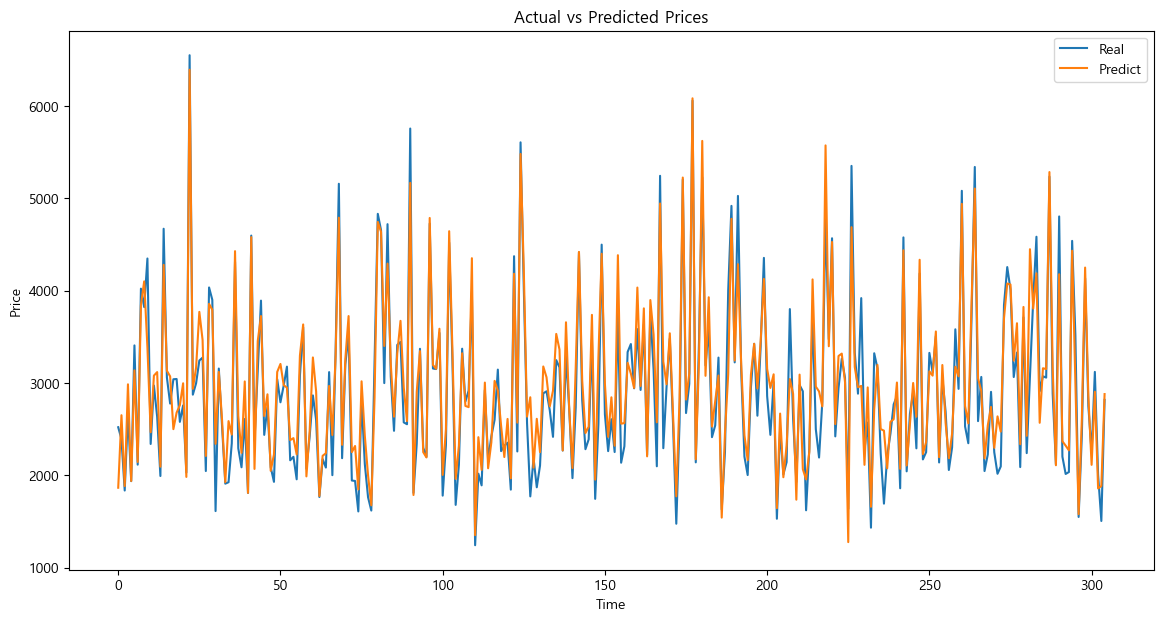

In [17]:
plt.figure(figsize=(14, 7))

plt.plot(y_test_inv, label='Real')
plt.plot(y_pred, label='Predict')

plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# 예측
y_train_pred_scaled = best_model.predict(x_train)
y_test_pred_scaled = best_model.predict(x_test)

# 역변환
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test)

y_train_inv = scaler_y.inverse_transform(y_train)
y_test_inv = scaler_y.inverse_transform(y_test)

# 성능 지표 계산
train_mae = mean_absolute_error(y_train_inv, y_train_pred)
train_mse = mean_squared_error(y_train_inv, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, y_train_pred)

test_mae = mean_absolute_error(y_test_inv, y_test_pred)
test_mse = mean_squared_error(y_test_inv, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_inv, y_test_pred)

print("Train Mean Absolute Error (MAE):", train_mae)
print("Train Mean Squared Error (MSE):", train_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R² Score:", train_r2)

print("Test Mean Absolute Error (MAE):", test_mae)
print("Test Mean Squared Error (MSE):", test_mse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print("Test R² Score:", test_r2)

Train Mean Absolute Error (MAE): 178.26159558555005
Train Mean Squared Error (MSE): 63561.41881036842
Train Root Mean Squared Error (RMSE): 252.11390047033984
Train R² Score: 0.9329958403744836
Test Mean Absolute Error (MAE): 0.0
Test Mean Squared Error (MSE): 0.0
Test Root Mean Squared Error (RMSE): 0.0
Test R² Score: 1.0


은닉층(LSTM) 3개

In [ ]:
def create_model(optimizer='adam', lstm_units=50, dropout_rate=0.1, activation='relu'):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 150],
    'model__lstm_units': [50, 100, 150],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0.4],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'softmax']
}

# KerasRegressor로 래핑
model = KerasRegressor(model=create_model, verbose=0)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search_result = grid_search.fit(x_train, y_train)

print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))
best_model = grid_search_result.best_estimator_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best: 0.871273 using {'batch_size': 32, 'epochs': 150, 'model__activation': 'relu', 'model__dropout_rate': 0.1, 'model__lstm_units': 150, 'model__optimizer': 'adam'}


Best: 0.871273 using {'batch_size': 32, 'epochs': 150, 'model__activation': 'relu', 'model__dropout_rate': 0.1, 'model__lstm_units': 150, 'model__optimizer': 'adam'}

In [ ]:
# train_loss = best_model.evaluate(x_train, y_train)
# test_loss = best_model.evaluate(x_test, y_test)
# print("Train Loss:", train_loss)
# print("Test Loss:", test_loss)

# train
y_train_pred_scaled = best_model.predict(x_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_inv = scaler_y.inverse_transform(y_train)

train_mae = mean_absolute_error(y_train_inv, y_train_pred)
train_mse = mean_squared_error(y_train_inv, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, y_train_pred)

print("Train Mean Absolute Error (MAE):", train_mae)
print("Train Mean Squared Error (MSE):", train_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R² Score:", train_r2)

# test
y_pred_scaled = best_model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# print("LSTM 예측 결과:", y_pred)

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print("Test Mean Absolute Error (MAE):", mae)
print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", rmse)
print("Test R² Score:", r2)

Train Mean Absolute Error (MAE): 192.65356074844206
Train Mean Squared Error (MSE): 64464.26330091709
Train Root Mean Squared Error (RMSE): 253.8981356783013
Train R² Score: 0.9348316368314389
Test Mean Absolute Error (MAE): 250.47051848798404
Test Mean Squared Error (MSE): 133446.99657064152
Test Root Mean Squared Error (RMSE): 365.30397831209217
Test R² Score: 0.8321055757498648


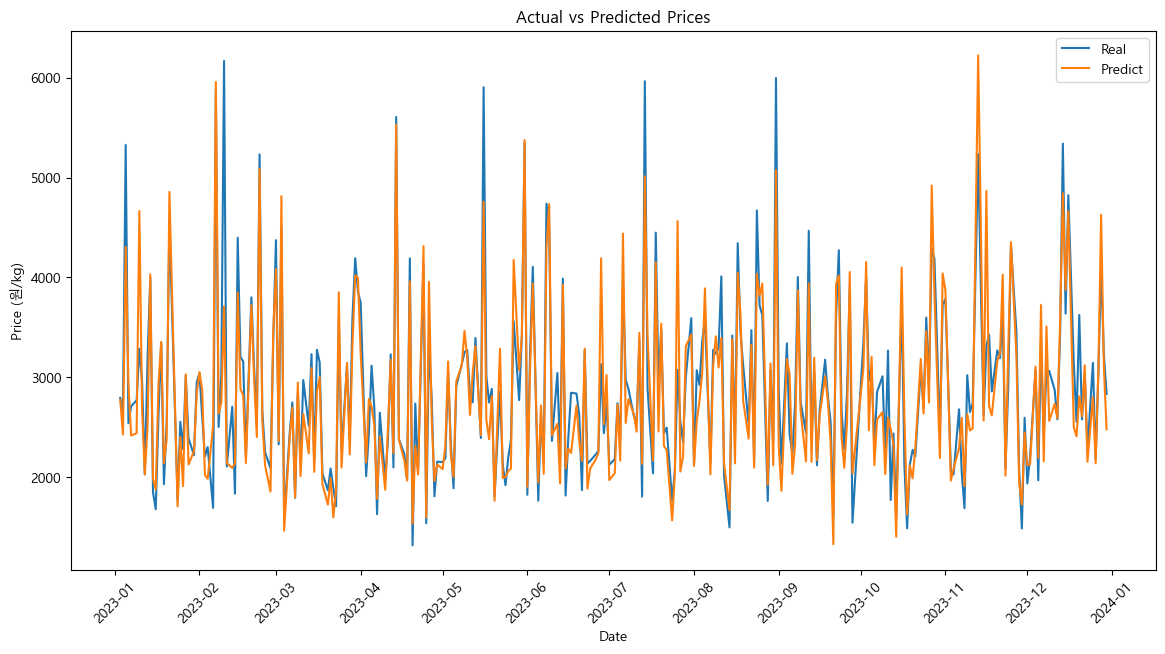

In [ ]:
dates = df['date'].iloc[-len(y_test):]
dates = pd.to_datetime(dates)

plt.figure(figsize=(14, 7))
plt.plot(dates, y_test_inv, label='Real')
plt.plot(dates, y_pred, label='Predict')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Date')
plt.ylabel('Price (원/kg)')
plt.title('Actual vs Predicted Prices')
plt.legend()
# plt.grid(True)
plt.xticks(rotation=45)
plt.show()

은닉층 2개

In [ ]:
def create_model(optimizer='adam', lstm_units=50, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 150],
    'model__lstm_units': [50, 100, 150],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0.4],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'softmax']
}

# KerasRegressor로 래핑
model = KerasRegressor(model=create_model, verbose=0)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search_result = grid_search.fit(x_train, y_train)

print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))
best_model = grid_search_result.best_estimator_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best: 0.858864 using {'batch_size': 32, 'epochs': 150, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__lstm_units': 100, 'model__optimizer': 'adam'}


Best: 0.858864 using {'batch_size': 32, 'epochs': 150, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__lstm_units': 100, 'model__optimizer': 'adam'}

In [ ]:
# train_loss = best_model.evaluate(x_train, y_train)
# test_loss = best_model.evaluate(x_test, y_test)
# print("Train Loss:", train_loss)
# print("Test Loss:", test_loss)

# train
y_train_pred_scaled = best_model.predict(x_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_inv = scaler_y.inverse_transform(y_train)

train_mae = mean_absolute_error(y_train_inv, y_train_pred)
train_mse = mean_squared_error(y_train_inv, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, y_train_pred)

print("Train Mean Absolute Error (MAE):", train_mae)
print("Train Mean Squared Error (MSE):", train_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R² Score:", train_r2)

# test
y_pred_scaled = best_model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# print("LSTM 예측 결과:", y_pred)

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print("Test Mean Absolute Error (MAE):", mae)
print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", rmse)
print("Test R² Score:", r2)

Train Mean Absolute Error (MAE): 200.81827425161657
Train Mean Squared Error (MSE): 75056.60163099947
Train Root Mean Squared Error (RMSE): 273.96459922953454
Train R² Score: 0.9241236055013228
Test Mean Absolute Error (MAE): 238.93886028948148
Test Mean Squared Error (MSE): 137962.31597613372
Test Root Mean Squared Error (RMSE): 371.4327879659168
Test R² Score: 0.8264246914184645


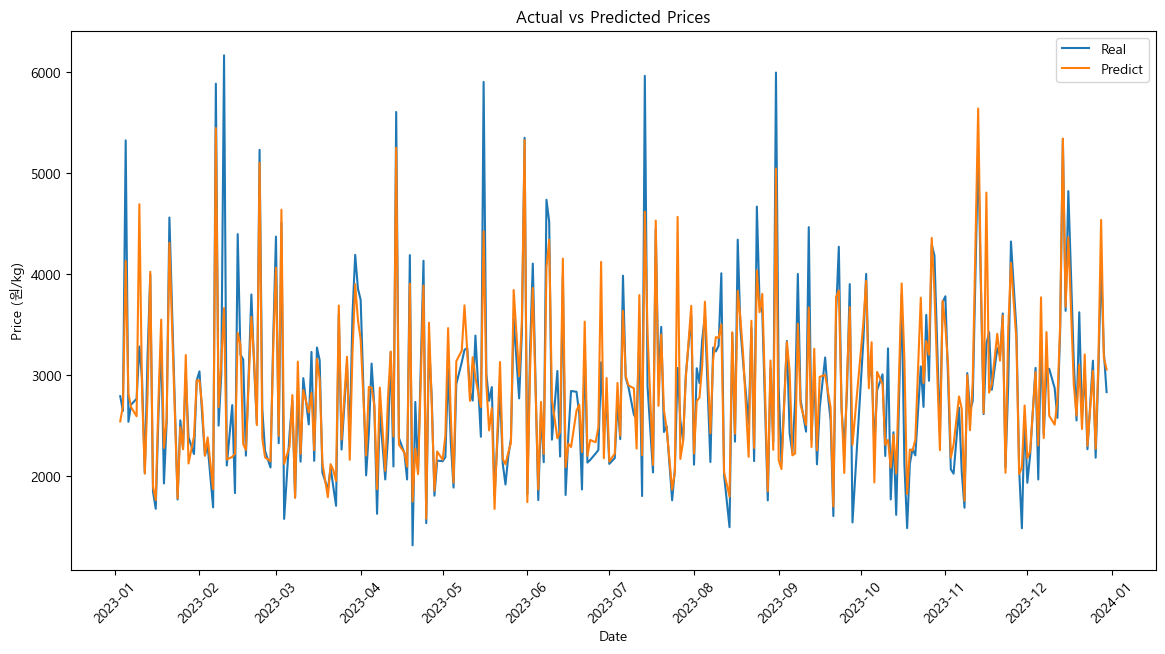

In [ ]:
dates = df['date'].iloc[-len(y_test):]
dates = pd.to_datetime(dates)

plt.figure(figsize=(14, 7))
plt.plot(dates, y_test_inv, label='Real')
plt.plot(dates, y_pred, label='Predict')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Date')
plt.ylabel('Price (원/kg)')
plt.title('Actual vs Predicted Prices')
plt.legend()
# plt.grid(True)
plt.xticks(rotation=45)
plt.show()

RandomForest보다 정확도가 높아 모델을 잘 설명해주고 있으며 과적합이 일어나지 않아 LSTM 모델로 결정

- 7일 후 가격 예측

In [13]:
df['target'] = df['사과_가격(원/kg)'].shift(-7)  # 7일 후의 사과 가격을 예측
df.dropna(inplace=True)

feature = ['사과_거래량(kg)', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', 'year', 'month', 'day', 'resid']
x = df[feature]
y = df['target']

# 데이터 스케일링
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# x,y는 2D 배열로 변환하여 스케일링
x_scaled = scaler_x.fit_transform(x)
y = y.values.reshape(-1, 1)
y_scaled = scaler_y.fit_transform(y)

# 시계열 데이터 형태로 변환 (samples, timesteps, feature)
def create_sequences(data, target, step):
    x_seq, y_seq = [], []
    for i in range(len(data) - step):
        x_seq.append(data[i:i + step])
        y_seq.append(target[i + step])
    return np.array(x_seq), np.array(y_seq)

timesteps = 7
x_lstm, y_lstm = create_sequences(x_scaled, y_scaled, timesteps)


x_train, x_test, y_train, y_test = train_test_split(x_lstm, y_lstm, test_size=0.25, random_state=42)

batch_size = 32  # 배치 크기 변경
epochs = 150  # 에폭 수 증가
dropout_rate = 0.1  # Dropout 비율 증가

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(dropout_rate))
model.add(LSTM(50))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_test, y_test), callbacks=[early_stopping], verbose=2)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
29/29 - 7s - 236ms/step - loss: 0.0341 - val_loss: 0.0253
Epoch 2/150
29/29 - 2s - 57ms/step - loss: 0.0254 - val_loss: 0.0252
Epoch 3/150
29/29 - 0s - 13ms/step - loss: 0.0254 - val_loss: 0.0241
Epoch 4/150
29/29 - 1s - 25ms/step - loss: 0.0260 - val_loss: 0.0234
Epoch 5/150
29/29 - 1s - 27ms/step - loss: 0.0237 - val_loss: 0.0228
Epoch 6/150
29/29 - 0s - 17ms/step - loss: 0.0211 - val_loss: 0.0193
Epoch 7/150
29/29 - 1s - 24ms/step - loss: 0.0204 - val_loss: 0.0182
Epoch 8/150
29/29 - 0s - 17ms/step - loss: 0.0199 - val_loss: 0.0174
Epoch 9/150
29/29 - 1s - 18ms/step - loss: 0.0180 - val_loss: 0.0211
Epoch 10/150
29/29 - 1s - 21ms/step - loss: 0.0196 - val_loss: 0.0164
Epoch 11/150
29/29 - 0s - 15ms/step - loss: 0.0184 - val_loss: 0.0156
Epoch 12/150
29/29 - 1s - 22ms/step - loss: 0.0161 - val_loss: 0.0145
Epoch 13/150
29/29 - 0s - 13ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 14/150
29/29 - 0s - 12ms/step - loss: 0.0153 - val_loss: 0.0145
Epoch 15/150
29/29 - 0s - 14

In [14]:
train_loss = model.evaluate(x_train, y_train)
test_loss = model.evaluate(x_test, y_test)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# train
y_train_pred_scaled = model.predict(x_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_inv = scaler_y.inverse_transform(y_train)

train_mae = mean_absolute_error(y_train_inv, y_train_pred)
train_mse = mean_squared_error(y_train_inv, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, y_train_pred)

print("Train Mean Absolute Error (MAE):", train_mae)
print("Train Mean Squared Error (MSE):", train_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R² Score:", train_r2)

# test
y_pred_scaled = model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# print("LSTM 예측 결과:", y_pred)

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred)

print("Test Mean Absolute Error (MAE):", mae)
print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", rmse)
print("Test R² Score:", r2)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 
Train Loss: 0.002206614473834634
Test Loss: 0.0024882007855921984
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Train Mean Absolute Error (MAE): 192.41852961185924
Train Mean Squared Error (MSE): 75765.76502850336
Train Root Mean Squared Error (RMSE): 275.2558174289934
Train R² Score: 0.9224437452032709
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test Mean Absolute Error (MAE): 206.641747909461
Test Mean Squared Error (MSE): 85434.2315928543
Test Root Mean Squared Error (RMSE): 292.291347105682
Test R² Score: 0.8993474587879292


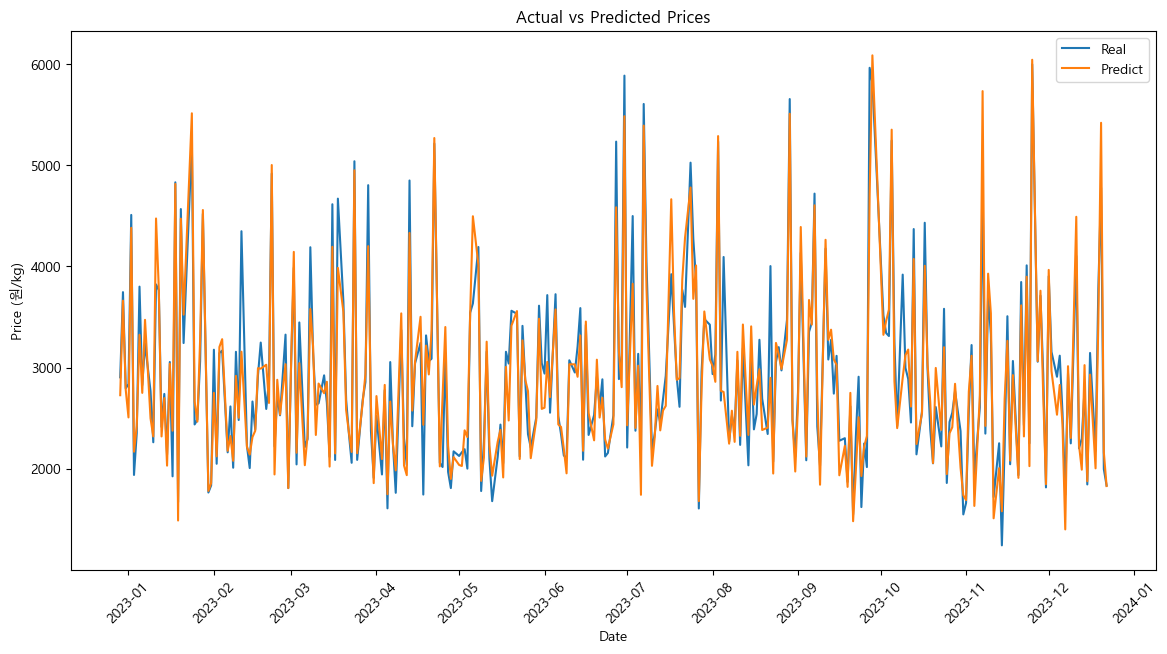

In [15]:
dates = df['date'].iloc[-len(y_test):]
dates = pd.to_datetime(dates)

plt.figure(figsize=(14, 7))
plt.plot(dates, y_test_inv, label='Real')
plt.plot(dates, y_pred, label='Predict')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Date')
plt.ylabel('Price (원/kg)')
plt.title('Actual vs Predicted Prices')
plt.legend()
# plt.grid(True)
plt.xticks(rotation=45)
plt.show()